In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping

import shap
import optuna
from tqdm import tqdm


In [ ]:
df = pd.read_pickle('C:\\diplomka_work\\python_code\\data_pickles\\weather_data.pkl')

In [31]:
product_counts = df['produkt_nazev'].value_counts()

df = df[df['produkt_nazev'].isin(product_counts[product_counts >= 200].index)]

In [32]:
df = df.sort_values(by=['doklad_id_int', 'poradi'])

# Vytvorenie sekvencie položiek v rámci každej objednávky
df['item_sequence'] = df.groupby('doklad_id_int').cumcount() + 1

# Výpočet kumulatívnej hodnoty objednávky pre každú položku
df['cumulative_order_value'] = df.groupby('doklad_id')['POLOZKA_CENA_VCETNE_DPH_PO_SLEVE'].cumsum()

# print

print(df[['doklad_id_int', 'produkt_id_int', 'poradi', 'item_sequence', 'cumulative_order_value']])

        doklad_id_int  produkt_id_int  poradi  item_sequence  \
0                   1               1       2              1   
2                   1               3       4              2   
1                   1               4       5              3   
24                  2               5       2              1   
23                  2               3       3              2   
...               ...             ...     ...            ...   
391727         134222              21       4              3   
391723         134223              23       1              1   
391724         134223             275       3              2   
391722         134223              43       5              3   
391721         134224              28       1              1   

        cumulative_order_value  
0                     119.0020  
2                     243.5585  
1                     287.9945  
24                     35.0570  
23                    158.0040  
...                        ...  


In [33]:
# nova premenná ktorá hovorí či bol produkt_id už v objednávke

In [34]:
unique_products = df['produkt_nazev'].unique()

# Inicializácia stĺpcov s hodnotami 0
for product in unique_products:
    df[f'product_{product}_before'] = 0

# Funkcia na nastavenie hodnôt pre každý riadok
def set_previous_products(group):
    previous = set()
    for index, row in group.iterrows():
        for product in unique_products:
            if product in previous:
                group.at[index, f'product_{product}_before'] = 1
        previous.add(row['produkt_nazev'])
    return group

# Aplikácia funkcie na každý doklad
df = df.groupby('doklad_id', group_keys=False).apply(set_previous_products)

# Zobrazenie výsledku
print(df.head())

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

                           doklad_id   produkt_id  \
0   f3c40a14064dfd9178bb281ddcb987fd  BC.P.TBA453   
2   f3c40a14064dfd9178bb281ddcb987fd  BC.P.DZU.83   
1   f3c40a14064dfd9178bb281ddcb987fd  BC.P.SAL.07   
24  1d66758ef41a978bc650bfcd4fe47f7d  BC.P.MIN.20   
23  1d66758ef41a978bc650bfcd4fe47f7d  BC.P.DZU.83   

                  produkt_nazev  is_bageta  is_pecivo  poradi  \
0              Double Bruselská          1          0       2   
2          Fresh pomeranč 0,5 l          0          0       4   
1   Patatas s tatarskou omáčkou          0          0       5   
24                    Ham & Egg          0          0       2   
23         Fresh pomeranč 0,5 l          0          0       3   

    pata_za_polovinu  sleva  sleva_bagety   datetime  ...  \
0                  0      0             0 2023-09-20  ...   
2                  0      0             0 2023-09-20  ...   
1                  0      0             0 2023-09-20  ...   
24                 0      0             0 2023

In [35]:
column_names_dumm = ['produkt_nazev']

In [36]:
df_dum = pd.get_dummies(df, columns = column_names_dumm)

In [37]:

# VYMAZ STLCPOV KVOLI DATALEAKGE
df = df.drop(['datetime','UCTENKA_CENA_VCETNE_DPH_PO_SLEVE','kod_uctenky' ], axis=1)



In [38]:
# Zoznam stĺpcov, ktoré chceš odstrániť, ak existujú
columns_to_drop = [
    'uzavreni_datum_cas', 'ucetni_datum', 'rozhodne_datum',
    'trvani', 'doba_otevreni_uctenky_sec',
    'UCTENKA_CENA_VCETNE_DPH_PO_SLEVE', 'kod_uctenky',
    'produkt_nazev.1', 'restaurace_nazev', 'restaurant_id',
    'produktova_rada', 'kategorie_segmentu']

# Odstráni len tie stĺpce, ktoré skutočne existujú v data_prep_1
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Načítanie dát (použi tvoje dáta)
# df = pd.read_csv('df_vzorek.csv')

# Pridanie stĺpca `next_product_id`
df['next_product_name'] = df.groupby('doklad_id_int')['produkt_nazev'].shift(-1)

# Označenie, či je riadok posledný v objednávke
df['is_last'] = df['next_product_name'].isna()

# Odstránenie riadkov, kde je `is_last` True
df = df[~df['is_last']].copy()


# Odstránenie tried, ktoré majú menej ako 2 vzorky
class_counts = df['next_product_name'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df['next_product_name'].isin(valid_classes)].copy()

# Automatický výber všetkých čŕt okrem identifikátorov a cieľových premenných
exclude_columns = ['doklad_id', 'produkt_id', 'item_sequence', 'poradi', 'next_product_name', 'next_product_id_encoded', 'is_last','produkt_nazev','doklad_id_int']
features = [col for col in df.columns if col not in exclude_columns]

X = df[features]
y = df['next_product_name']

# Rozdelenie dát na tréningovú a testovaciu množi


In [ ]:
import pandas as pd
import numpy as np
import datetime
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import optuna
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import pandas as pd




In [41]:
df = pd.read_pickle('C:\\diplomka_work\\python_code\\data_pickles\\df_weather_pred.pkl')

In [42]:

import re

# Oprava názvov stĺpcov (odstránenie špeciálnych znakov)
X.columns = [re.sub(r'[^A-Za-z0-9_]', '_', col) for col in X.columns]

In [43]:
# Rozdelenie dát na tréningovú a testovaciu množinu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

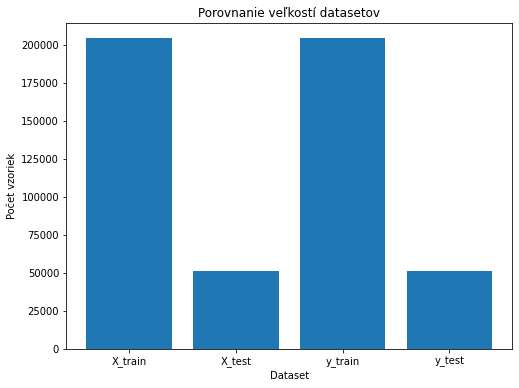

In [44]:
import matplotlib.pyplot as plt

# Získanie veľkostí jednotlivých datasetov
sizes = {
    "X_train": len(X_train),
    "X_test": len(X_test),
    "y_train": len(y_train),
    "y_test": len(y_test),
}

# Vytvorenie grafu
plt.figure(figsize=(8, 6))
plt.bar(sizes.keys(), sizes.values())
plt.xlabel("Dataset")
plt.ylabel("Počet vzoriek")
plt.title("Porovnanie veľkostí datasetov")
plt.show()


In [ ]:
#optuna zakomentovane 

# Kódovanie cieľovej premennej (Label Encoding)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Rozdelenie datasetu na trénovaciu a testovaciu množinu
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)



# Definovanie cieľovej funkcie pre Optunu
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),  # Počet iterácií
        "max_depth": trial.suggest_int("max_depth", 3, 12),  # Hĺbka stromov
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),  # Learning rate
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),  # Počet listov na strome
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),  # Min vzoriek v liste
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10),  # L1 regularizácia
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10),  # L2 regularizácia
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Bagging
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Výber čŕt
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 0.2),  # Práh pre split
        "n_jobs": -1,  # Využitie všetkých CPU jadier
        "random_state": 42
    }

    # Trénovanie modelu
    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        callbacks=[early_stopping(50, verbose=False)]  # **Použitý správny spôsob Early Stopping**
    )

    # Predikcia
    y_pred = model.predict(X_test)

    # Vyhodnotenie presnosti
    return accuracy_score(y_test, y_pred)

# Spustenie Optuny s viac iteráciami
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1)  # 50 skúšok pre lepšiu optimalizáciu

# Najlepšie parametre
best_params = study.best_params
print("Najlepšie parametre:", best_params)

# Trénovanie finálneho modelu s najlepšími parametrami
final_model = LGBMClassifier(**best_params, n_jobs=-1)
final_model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)], 
    callbacks=[early_stopping(50, verbose=True)]  # Použitie Early Stopping v správnom formáte
)

# Predikcia na testovacej množine
y_pred_final = final_model.predict(X_test)

# Vyhodnotenie finálneho modelu
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Optimized LightGBM Test Accuracy: {final_accuracy:.4f}")



In [46]:
# --- Label encoding cieľa ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)


In [49]:
best_params = {
    'n_estimators': 968,
    'max_depth': 12,
    'learning_rate': 0.058150279902079646,
    'num_leaves': 88,
    'min_child_samples': 21,
    'reg_alpha': 3.107556377029464,
    'reg_lambda': 7.462364831089772,
    'subsample': 0.849093744561868,
    'colsample_bytree': 0.6941616724742281,
    'min_split_gain': 0.13962350481521754
}


In [50]:

# --- Trénovanie finálneho modelu ---
final_model = LGBMClassifier(**best_params)

In [51]:
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(80, verbose=True)]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2257
[LightGBM] [Info] Number of data points in the train set: 204329, number of used features: 214
[LightGBM] [Info] Start training from score -6.449834
[LightGBM] [Info] Start training from score -7.456802
[LightGBM] [Info] Start training from score -3.445010
[LightGBM] [Info] Start training from score -6.369554
[LightGBM] [Info] Start training from score -6.081157
[LightGBM] [Info] Start training from score -4.170426
[LightGBM] [Info] Start training from score -6.793765
[LightGBM] [Info] Start training from score -4.811108
[LightGBM] [Info] Start training from score -4.897082
[LightGBM] [Info] Start training from score -5.200172
[LightGBM] [Info] Start training from score -5.078355
[LightGBM] [Info] Start training from score -7.3676

LGBMClassifier(colsample_bytree=0.6941616724742281,
               learning_rate=0.058150279902079646, max_depth=12,
               min_child_samples=21, min_split_gain=0.13962350481521754,
               n_estimators=968, num_leaves=88, reg_alpha=3.107556377029464,
               reg_lambda=7.462364831089772, subsample=0.849093744561868)

In [ ]:
# Predpokladáme, že final_model je natrénovaný LightGBM model
import pandas as pd
import matplotlib.pyplot as plt

# Získame dôležitosť podľa GAIN (prípadne 'split' ak chceš počet použití)
importances_gain = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.booster_.feature_name()

# Zabaliť do DataFrame
gain_importance_df = pd.DataFrame({'Premenná': feature_names, 'Dôležitosť (Gain)': importances_gain})
gain_importance_df = gain_importance_df.sort_values(by='Dôležitosť (Gain)', ascending=False)

# Výpis tabuľky
print("\nDôležitosť premenných podľa Gain:")
print(gain_importance_df)



Dôležitosť premenných podľa Gain:
                                          Premenná  Dôležitosť (Gain)
7                 POLOZKA_CENA_VCETNE_DPH_PO_SLEVE      635057.248168
88                          cumulative_order_value      354556.411698
70                               segment_RYCHLOVKY      242166.886660
16                                  produkt_id_int      220870.135591
30                                      typ_kasy_K      208023.507384
..                                             ...                ...
177               product_Minibagetka_tmav__before           0.000000
185                      product__aj_ovocn__before           0.000000
186                  product_Dresink_Caesar_before           0.000000
196                      product__aj_m_tov__before           0.000000
143  product_Dar_pro_Institut_Pam_ti_n_roda_before           0.000000

[248 rows x 2 columns]



Dôležitosť premenných podľa Gain:
                            Premenná  Dôležitosť (Gain)  Dôležitosť (%)
7   POLOZKA_CENA_VCETNE_DPH_PO_SLEVE       1.339373e+06       18.688434
87            cumulative_order_value       7.385786e+05       10.305476
15                    produkt_id_int       4.980545e+05        6.949415
69                 segment_RYCHLOVKY       3.449057e+05        4.812511
11                          has_menu       3.161778e+05        4.411668
29                        typ_kasy_K       2.492593e+05        3.477945
63                   segment_PATATAS       2.307524e+05        3.219716
5                               HOUR       2.099435e+05        2.929367
16                      Month_Number       1.882075e+05        2.626083
12                   has_superpytlik       1.806204e+05        2.520218
41                  food_drink_DRINK       1.645049e+05        2.295356
64                  segment_PATATASR       1.548555e+05        2.160717
14                       has_

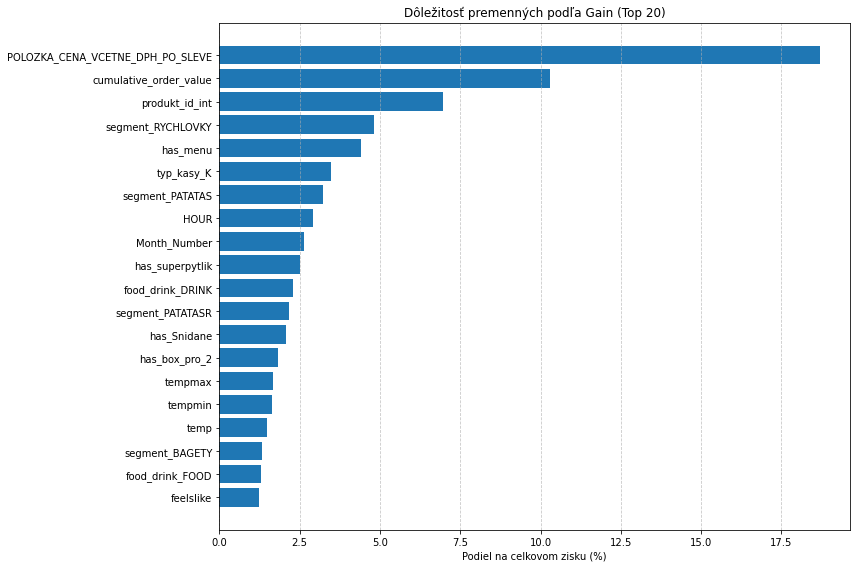


Graf uložený ako 'gain_importance_top20.png'.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Získanie dôležitosti podľa Gain
importances_gain = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.booster_.feature_name()

gain_importance_df = pd.DataFrame({
    'Premenná': feature_names,
    'Dôležitosť (Gain)': importances_gain
})

# Normalizácia (percentá)
gain_importance_df['Dôležitosť (%)'] = 100 * gain_importance_df['Dôležitosť (Gain)'] / gain_importance_df['Dôležitosť (Gain)'].sum()

# Zoradenie
gain_importance_df = gain_importance_df.sort_values(by='Dôležitosť (Gain)', ascending=False)

# Výpis tabuľky
print("\nDôležitosť premenných podľa Gain:")
print(gain_importance_df.head(20))

# 2. Uloženie výsledkov
gain_importance_df.to_csv('gain_importance.csv', index=False, encoding='utf-8-sig')





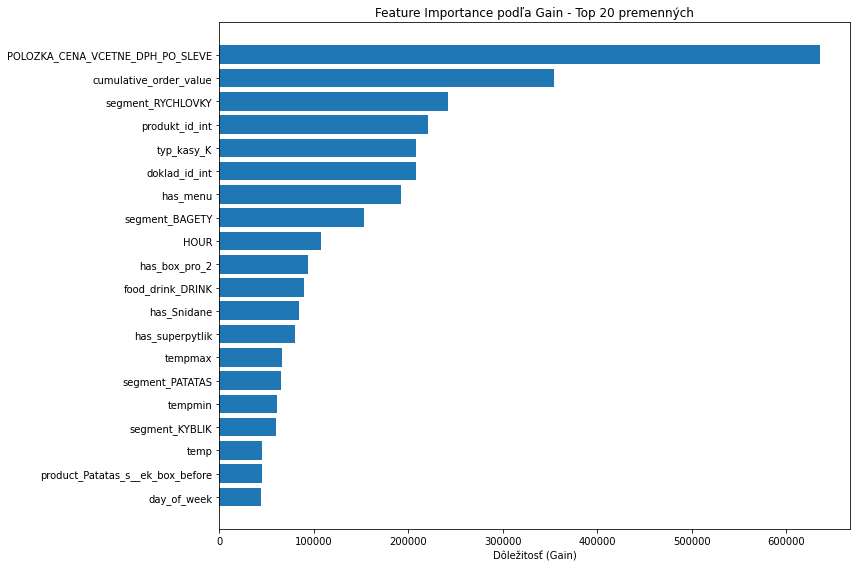

In [ ]:
# Vizualizácia
plt.figure(figsize=(12, 8))
plt.barh(gain_importance_df['Premenná'].head(20), gain_importance_df['Dôležitosť (Gain)'].head(20))
plt.xlabel('Dôležitosť (Gain)')
plt.title('Feature Importance podľa Gain - Top 20 premenných')
plt.gca().invert_yaxis()  # Najdôležitejšie hore
plt.tight_layout()
plt.show()


Spracované: 100.00% | Odhad zostávajúceho času: 0.00 minn
Výpočet hotový.

Permutačná dôležitosť - Top 50 premenných:
                                      Premenná  \
0             POLOZKA_CENA_VCETNE_DPH_PO_SLEVE   
5                                   typ_kasy_K   
1                       cumulative_order_value   
3                            segment_RYCHLOVKY   
4                                     has_menu   
9                              has_superpytlik   
11                            segment_PATATASR   
2                               produkt_id_int   
27  product_Patatas_s_tatarskou_om__kou_before   
13                               has_box_pro_2   
6                              segment_PATATAS   
8                                 Month_Number   
10                            food_drink_DRINK   
7                                         HOUR   
20                        typ_objednavky_sebou   
34                product_Ice_tea_0_4_l_before   
12                              

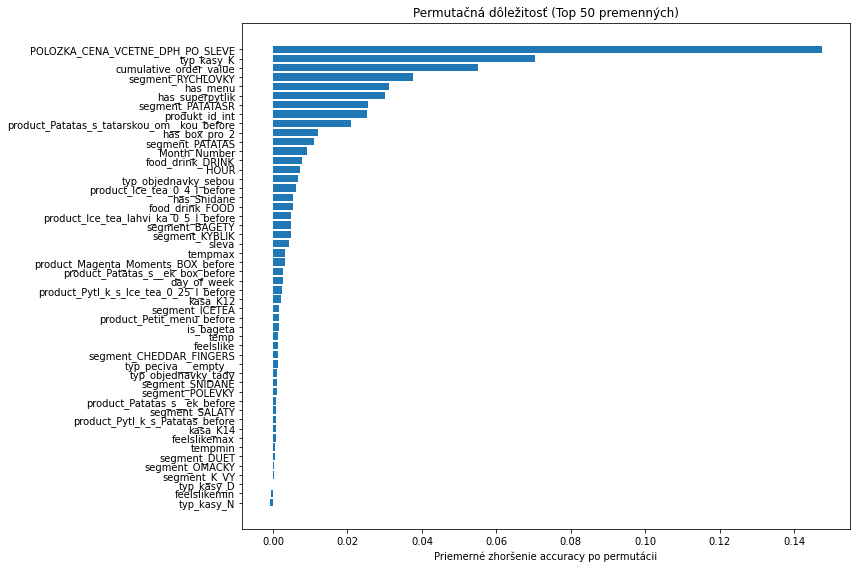

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score

# 1. Reset indexov
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)

# 2. Sampling
sample_size = 12000
X_test_sample = X_test_reset.sample(n=sample_size, random_state=42)
y_test_sample = y_test_reset.loc[X_test_sample.index]

# 3. Feature Importance podľa Gain
gain_importance = final_model.booster_.feature_importance(importance_type='gain')
feature_names = final_model.booster_.feature_name()

gain_importance_df = pd.DataFrame({
    'Premenná': feature_names,
    'Gain': gain_importance
}).sort_values(by='Gain', ascending=False)

# 4. Výber TOP 50 najdôležitejších premenných
top_features = gain_importance_df['Premenná'].head(50).tolist()

# 5. Príprava pre manuálnu permutáciu
n_repeats = 5
results = []

# Vypočítaj základné skóre modelu na nepremutovaných dátach
y_pred_original = final_model.predict(X_test_sample)
baseline_score = accuracy_score(y_test_sample, y_pred_original)

# 6. Manuálny výpočet permutácií s priebehom
start_time = time.time()
total_steps = len(top_features) * n_repeats
current_step = 0

for feature in top_features:
    scores = []
    for repeat in range(n_repeats):
        # Nakopíruj sample, permutuj jednu premennú
        X_permuted = X_test_sample.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        # Predikcia a výpočet accuracy
        y_pred = final_model.predict(X_permuted)
        score = accuracy_score(y_test_sample, y_pred)
        scores.append(score)

        # Update priebehu
        current_step += 1
        elapsed = time.time() - start_time
        percent_complete = (current_step / total_steps) * 100
        estimated_total_time = elapsed / (current_step / total_steps)
        estimated_remaining = estimated_total_time - elapsed

        print(f"\rSpracované: {percent_complete:.2f}% | Odhad zostávajúceho času: {estimated_remaining/60:.2f} min", end="")

    # Výpočet priemerného zhoršenia skóre
    mean_importance = baseline_score - np.mean(scores)
    results.append((feature, mean_importance))


# 7. Spracovanie výsledkov
perm_importance_df = pd.DataFrame(results, columns=['Premenná', 'Dôležitosť (priemer zhoršenia skóre)'])
perm_importance_df = perm_importance_df.sort_values(by='Dôležitosť (priemer zhoršenia skóre)', ascending=False)

# 8. Výpis
print("\nPermutačná dôležitosť - Top 50 premenných:")
print(perm_importance_df)

# 9. Vizualizácia
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['Premenná'], perm_importance_df['Dôležitosť (priemer zhoršenia skóre)'])
plt.xlabel('Priemerné zhoršenie accuracy po permutácii')
plt.title('Permutačná dôležitosť (Top 50 premenných)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# 10. Uloženie výsledkov do Excelu
perm_importance_df.to_excel('permutation_importance_top50.xlsx', index=False)
print("\nVýsledky boli uložené do súboru 'permutation_importance_top50.xlsx'.")

# 11. Uloženie grafu do PNG
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['Premenná'], perm_importance_df['Dôležitosť (priemer zhoršenia skóre)'])
plt.xlabel('Priemerné zhoršenie accuracy po permutácii')
plt.title('Permutačná dôležitosť (Top 50 premenných)')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('permutation_importance_top50.png', dpi=300)
plt.close()





Výsledky boli uložené do súboru 'permutation_importance_top50.xlsx'.

Graf uložený ako 'permutation_importance_top50.png'.


In [ ]:
# 10. Uloženie výsledkov do CSV
perm_importance_df.to_csv('permutation_importance_top50.csv', index=False, encoding='utf-8-sig')




Výsledky boli uložené do súboru 'permutation_importance_top50.csv'.



Začínam počítať SHAP hodnoty na 500 vzorkách...

Výpočet SHAP hodnôt hotový za 25.67 sekúnd.

Top 10 premenných podľa priemernej absolútnej hodnoty SHAP:
                            Premenná  Priemerná absolútna hodnota SHAP
15                     doklad_id_int                          0.347312
7   POLOZKA_CENA_VCETNE_DPH_PO_SLEVE                          0.238269
88            cumulative_order_value                          0.210222
11                          has_menu                          0.139018
16                    produkt_id_int                          0.137928
5                               HOUR                          0.123930
6                        day_of_week                          0.103809
30                        typ_kasy_K                          0.097359
75                           tempmax                          0.076357
47                    segment_BAGETY                          0.063154


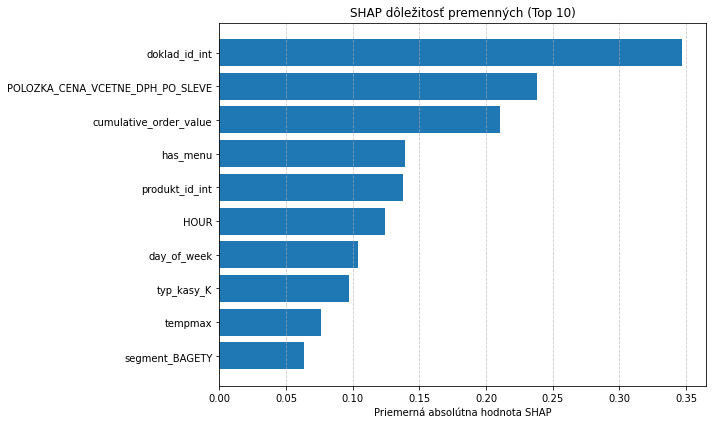

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. Reset indexov
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)

# 2. Sampling
sample_size = 500
X_test_sample = X_test_reset.sample(n=sample_size, random_state=42)

# 3. Explainer cez booster
booster = final_model.booster_
explainer = shap.TreeExplainer(booster)

# 4. Výpočet SHAP hodnôt
print(f"\nZačínam počítať SHAP hodnoty na {sample_size} vzorkách...")
start_time = time.time()

shap_values = explainer.shap_values(X_test_sample)

elapsed = time.time() - start_time
print(f"\nVýpočet SHAP hodnôt hotový za {elapsed:.2f} sekúnd.")

# 5. Spracovanie shap_values pre multiclass
# Ak je multiclass, shap_values je list
if isinstance(shap_values, list):
    # Spriemerujeme absolútne hodnoty cez všetky triedy
    mean_shap_per_class = [np.abs(class_shap).mean(axis=0) for class_shap in shap_values]
    mean_shap = np.mean(mean_shap_per_class, axis=0)
else:
    mean_shap = np.abs(shap_values).mean(axis=0)

# 6. Vytvorenie tabuľky
shap_importance_df = pd.DataFrame({
    'Premenná': X_test_sample.columns,
    'Priemerná absolútna hodnota SHAP': mean_shap
}).sort_values(by='Priemerná absolútna hodnota SHAP', ascending=False)

# 7. Výpis Top 10
print("\nTop 10 premenných podľa priemernej absolútnej hodnoty SHAP:")
print(shap_importance_df.head(10))

# 8. Graf
top_10 = shap_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10['Premenná'], top_10['Priemerná absolútna hodnota SHAP'])
plt.xlabel('Priemerná absolútna hodnota SHAP')
plt.title('SHAP dôležitosť premenných (Top 10)')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Začínam počítať SHAP hodnoty na 12000 vzorkách...

Výpočet SHAP hodnôt hotový za 11.97 minút.

Top 50 premenných podľa priemernej absolútnej hodnoty SHAP:
                                       Premenná  \
16                                 Month_Number   
7              POLOZKA_CENA_VCETNE_DPH_PO_SLEVE   
87                       cumulative_order_value   
11                                     has_menu   
5                                          HOUR   
15                               produkt_id_int   
76                                         temp   
6                                   day_of_week   
29                                   typ_kasy_K   
74                                      tempmax   
75                                      tempmin   
79                                    feelslike   
31                         typ_objednavky_sebou   
78                                 feelslikemin   
90   product_Patatas_s_tatarskou_om__kou_before   
46                          

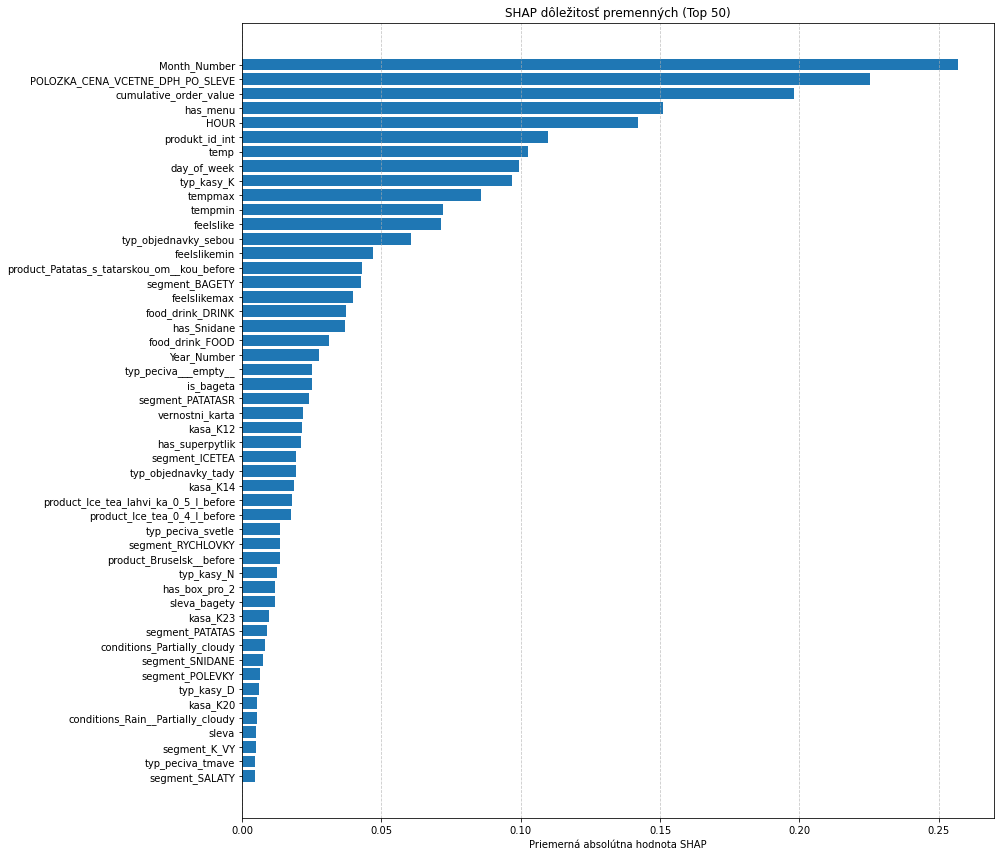


Graf uložený ako 'shap_top50.png'.


In [ ]:

# 1. Reset indexov
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)

# 2. Sampling - teraz na 12 000 vzorkách
sample_size = 12000
X_test_sample = X_test_reset.sample(n=sample_size, random_state=42)

# 3. Explainer cez booster
booster = final_model.booster_
explainer = shap.TreeExplainer(booster)

# 4. Výpočet SHAP hodnôt

start_time = time.time()

shap_values = explainer.shap_values(X_test_sample)

elapsed = time.time() - start_time
print(f"\nVýpočet SHAP hodnôt hotový za {elapsed/60:.2f} minút.")

# 5. Spracovanie shap_values pre multiclass
if isinstance(shap_values, list):
    mean_shap_per_class = [np.abs(class_shap).mean(axis=0) for class_shap in shap_values]
    mean_shap = np.mean(mean_shap_per_class, axis=0)
else:
    mean_shap = np.abs(shap_values).mean(axis=0)

# 6. Uloženie výsledkov
shap_importance_df = pd.DataFrame({
    'Premenná': X_test_sample.columns,
    'Priemerná absolútna hodnota SHAP': mean_shap
}).sort_values(by='Priemerná absolútna hodnota SHAP', ascending=False)

# Výpis Top 50

print(shap_importance_df.head(50))

# Uloženie CSV
shap_importance_df.to_csv('shap_importance_top50.csv', index=False, encoding='utf-8-sig')


# 7. Vizualizácia Top 50
top_50 = shap_importance_df.head(50)

plt.figure(figsize=(14, 12))
plt.barh(top_50['Premenná'], top_50['Priemerná absolútna hodnota SHAP'])
plt.xlabel('Priemerná absolútna hodnota SHAP')
plt.title('SHAP dôležitosť premenných (Top 50)')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('shap_top50.png', dpi=300)  
plt.show()



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['Premenná'].head(20), perm_importance_df['Dôležitosť (priemer zhoršenia skóre)'].head(20))
plt.xlabel('Priemerné zhoršenie skóre po permutácii')
plt.title('Permutačná dôležitosť - Top 20 premenných')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
